In [1]:
# import and set options
import warnings
warnings.filterwarnings("ignore")
import matplotlib.style
import matplotlib as mpl
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import rpy2
%load_ext rpy2.ipython
import seaborn as sns
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import utils
mpl.rcParams['pdf.fonttype'] = 42

## CHASMplus comparison to PTEN saturation mutagenesis


In [2]:
# read data
chasmplus_df = pd.read_table('CHASMplus/data/PTEN/pten_saturation_mutagenesis.chasm2_output.txt')
phosphatase = pd.read_table('CHASMplus/data/PTEN/pten_saturation_mutagenesis.txt')
abundance = pd.read_table('CHASMplus/data/PTEN/Matreyek_et_al_pten_abundance.txt')

In [3]:
# format phophatase df
phosphatase['UID'] = range(len(phosphatase))
phosphatase = phosphatase.rename(columns={'Cum_score': 'lipid phosphatase activity'})

# format CHASMplus data
pten_driver_gene_score = 0.969
chasmplus_df['gwCHASMplus'] = chasmplus_df['driver'] * pten_driver_gene_score

# merge results
df = pd.merge(phosphatase, chasmplus_df[['UID', 'gwCHASMplus']], on='UID', how='left')
rename_dict = {
    'variant': 'Variant (one letter)',
    'score': 'protein abundance'
}
abundance = abundance.rename(columns=rename_dict)
mycols = ['Variant (one letter)', 'abundance_class', 'protein abundance']
df = pd.merge(df, abundance, on=mycols[0], how='left')

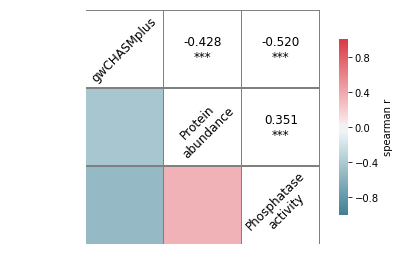

In [4]:
# initialize figure/axis
fig, ax = plt.subplots()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
rename_dict = {'driver': 'CHASMplus', 
               'protein abundance': 'Protein\nabundance', 
               'lipid phosphatase activity': 'Phosphatase\nactivity'}
columns = ['gwCHASMplus', 'protein abundance', 'lipid phosphatase activity']
corr = df[columns].rename(columns=rename_dict).corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# make heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmax=1.0, vmin=-1.0,
            square=True, linewidths=.25, linecolor='gray', 
            cbar_kws={"shrink": .75, 'label': 'spearman r'}, 
            ax=ax)

# add correlation numbers
for i in range(len(corr)):
    ax.text(i+0.5, (i+0.5), corr.columns[i], 
            ha="center", va="center", rotation=45, fontsize=12)
    for j in range(i+1, len(corr)):
        # figure out significance
        not_null = (~df[columns[i]].isnull()) & (~df[columns[j]].isnull())
        pval = stats.spearmanr(df.loc[not_null, columns[i]], df.loc[not_null, columns[j]])[1]
        mytext = 'ns'
        if pval <= 0.05: mytext = '*'
        if pval <= 0.01: mytext += '*'
        if pval <= 0.001: mytext += '*'
        
        # add text
        s = "{0:.3f}\n{1}".format(corr.values[i,j], mytext)
        ax.text(j+0.5,(i+0.5),s, 
                ha="center", va="center", fontsize=12)

# remove axes ticks
ax.axis('off')
plt.tight_layout()

# save results
plt.savefig('CHASMplus/figures/figure_5d.pdf')

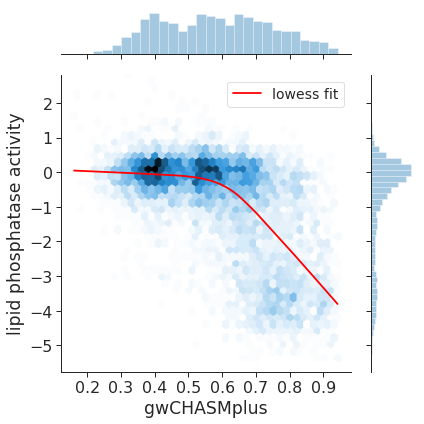

In [5]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.8):
    g = sns.jointplot('gwCHASMplus', 'lipid phosphatase activity', 
                      data=df, kind='hex')
    sns.regplot('gwCHASMplus', 'lipid phosphatase activity', data=df, lowess=True, 
                ax=g.ax_joint, color='red', scatter=False, label='lowess fit')
    g.ax_joint.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.savefig('CHASMplus/figures/figure_5b.pdf')

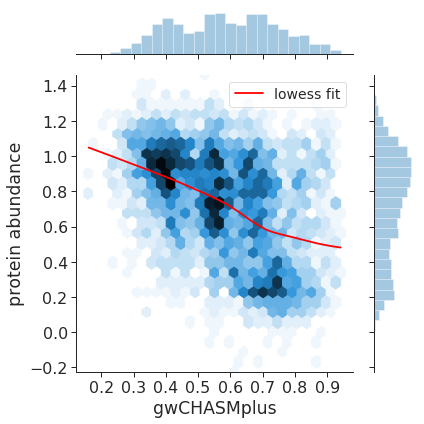

In [6]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.8):
    g = sns.jointplot('gwCHASMplus', 'protein abundance', 
                      data=df, kind='hex')
    sns.regplot('gwCHASMplus', 'protein abundance', data=df, lowess=True, 
                ax=g.ax_joint, color='red', scatter=False, label='lowess fit')
    g.ax_joint.legend(loc='best', fontsize=14)
plt.tight_layout()
plt.savefig('CHASMplus/figures/figure_5c.pdf')

### Plot in silico saturation mutagenesis

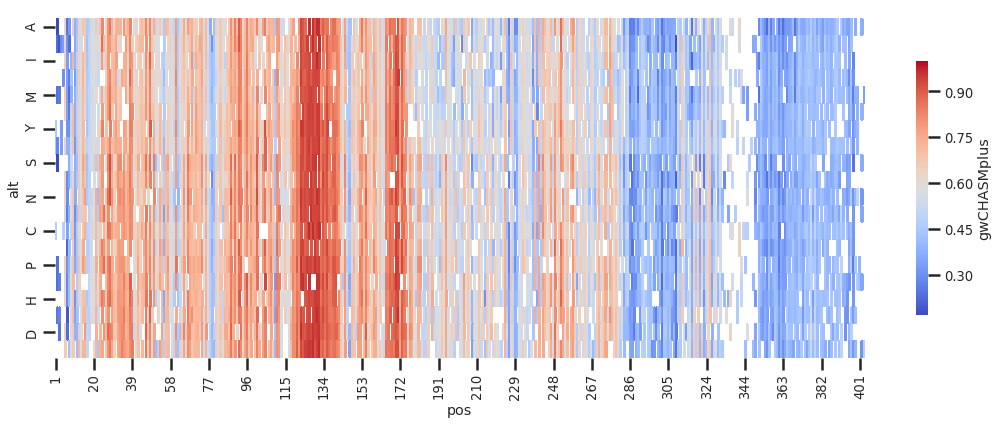

In [7]:
ref = chasmplus_df.ID.str.extract('_([A-Z])[0-9]+', expand=False)
pos = chasmplus_df.ID.str.extract('_[A-Z]([0-9]+)[A-Z]', expand=False).astype(int)
alt = chasmplus_df.ID.str.extract('_[A-Z][0-9]+([A-Z])', expand=False)
plot_df = chasmplus_df.copy()
plot_df['ref'] = ref
plot_df['alt'] = alt
plot_df['pos'] = pos
aa_order = ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'R', 'H', 'K', 'D', 'E']
tmp = pd.pivot_table(plot_df, values='driver', index='alt', columns='pos')
tmp = tmp.loc[aa_order]

with sns.plotting_context('poster', font_scale=.6), sns.axes_style('ticks'):
    fig, ax = plt.subplots()
    mask = tmp.isnull()
    #sns.color_palette("coolwarm", 7)
    sns.heatmap(tmp, mask=mask, square=False, 
                cbar_kws={'shrink':.75, 'label': 'gwCHASMplus',}, vmax=1,
                cmap="coolwarm", 
                ax=ax)
    fig.set_size_inches(15, 6)
plt.tight_layout()
plt.savefig('CHASMplus/figures/figure_5a.pdf')

### Examine characteristics of rare variants

In [8]:
rare_df = pd.read_table('CHASMplus/data/rarity_analysis/PANCAN.txt')
result_df = utils.read_result('PANCAN')

# read in truncating variants
other_var_df = pd.read_table('CHASMplus/data/pten/pten_saturation_mutagenesis_full.txt')
is_other_var = other_var_df['Type'].isin(['aa_del', 'nonsense'])
is_high_conf = other_var_df['High_conf']
other_var_df = other_var_df[(is_other_var & is_high_conf)].copy()
other_var_df['HGVSp_Short'] = 'p.' + other_var_df['Variant (one letter)']
other_var_df.loc[other_var_df['Type'].isin(['aa_del', 'nonsense',]), 'category'] = 'lof'
#other_var_df['abundance'] = np.nan
other_var_df = other_var_df.rename(columns={'Cum_score': 'lipid phosphatase activity'})

# merge in lof variants from abundance assay
tmp_abundance = abundance[abundance['class']=='nonsense'].copy()
tmp_abundance.loc[:,'Variant (one letter)'] = tmp_abundance['Variant (one letter)'].str[:-1] + '*'
mycols = ['Variant (one letter)', 'protein abundance']
other_var_df = pd.merge(other_var_df, tmp_abundance[mycols], on=mycols[0], how='left')

In [9]:
tmp = result_df[(result_df['Hugo_Symbol']=='PTEN') & (result_df['PANCAN']<=0.01)].drop_duplicates('HGVSp_Short')
tmp['mutation'] = tmp['Hugo_Symbol'] + '_' + tmp['Transcript_ID'] + '_' + tmp['Protein_position']
tmp = pd.merge(tmp, rare_df[['mutation', 'category']], on='mutation', how='left')
mycols = ['HGVSp_Short', 'Type', 'protein abundance', 'lipid phosphatase activity']
tmp2 = pd.merge(df[mycols], tmp[['HGVSp_Short', 'category']], on='HGVSp_Short', how='left')

In [10]:
tmp2 = pd.concat([tmp2, other_var_df[mycols+['category']]])
tmp2['category'] = tmp2['category'].fillna('all other missense')

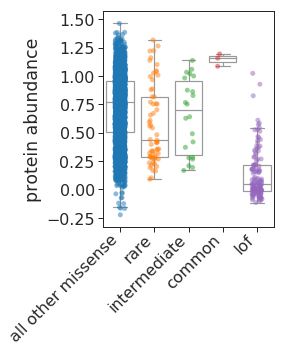

In [11]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots()
    sns.boxplot('category', 'protein abundance', data=tmp2, color='white', ax=ax, fliersize=0)
    sns.stripplot('category', 'protein abundance', data=tmp2, jitter=.15, alpha=.5, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', which='major', pad=0)
    plt.xlabel('')
    fig.set_size_inches(4, 5)
plt.tight_layout()
plt.savefig('CHASMplus/figures/figure_5f.pdf')

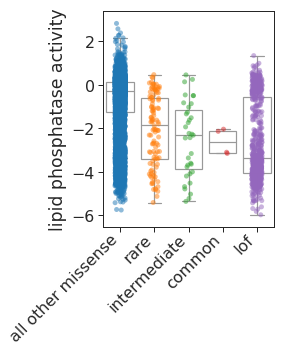

In [12]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots()
    sns.boxplot('category', 'lipid phosphatase activity', data=tmp2, color='white', ax=ax, fliersize=0)
    sns.stripplot('category', 'lipid phosphatase activity', data=tmp2, jitter=.15, ax=ax, alpha=.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', which='major', pad=0)
    plt.xlabel('')
    fig.set_size_inches(4, 5)
plt.tight_layout()
plt.savefig('CHASMplus/figures/figure_5e.pdf')

In [13]:
def mannwhitney_test(data):
    """Perform a mann-whitney u test on all columns of interest"""
    comparisons = ['rare', 'intermediate', 'common', 'lof']
    output = [['variable', 'rare p-value', 'intermediate p-value', 'common p-value', 'lof p-value']]
    for col in ['protein abundance', 'lipid phosphatase activity']:
        tmp_output = [col]
        for item in comparisons:
            other_mis = data[data['category']=='all other missense'][col].dropna()
            alt = data[data['category']==item][col].dropna()
            pvalue = stats.mannwhitneyu(other_mis, alt).pvalue
            tmp_output.append(pvalue)
        output.append(tmp_output)
    test_result_df = pd.DataFrame(output[1:], columns=output[0])
    return test_result_df

In [14]:
mannwhitney_test(tmp2)

,variable,rare p-value,intermediate p-value,common p-value,lof p-value
0,protein abundance,9.251990e-05,1.695218e-01,0.003617,5.052265e-59
1,lipid phosphatase activity,1.561478e-18,1.937234e-09,0.007993,1.577426e-112


In [11]:
# save supplementary table
supp_table = pd.merge(tmp2, df[['HGVSp_Short', 'gwCHASMplus']], on='HGVSp_Short', how='left')
supp_table.to_csv('CHASMplus/results/table_S6.txt', sep='\t', index=False)

### Comparison to ClinVar pathogenicity

In [15]:
# read PTEN clinvar data
pten_clinvar = pd.read_table('CHASMplus/data/pten/pten_clinvar.txt')

# process clinvar data
pten_clinvar['clinvar status'] = pten_clinvar['Clinical significance (Last reviewed)'].str.extract('([A-Za-z ]+)\(', expand=True)[0]
pten_clinvar['Variant (three letter)'] = pten_clinvar['Name'].str.extract('\(p\.([A-Za-z]+[0-9]+[A-Za-z]+)\)$', expand=True)[0]

# only keep missense variants and pathogenic variants
is_missense = ~pten_clinvar['Variant (three letter)'].isnull()
is_pathogenic = pten_clinvar['clinvar status'].isin(['Pathogenic', 'Likely pathogenic'])
has_criteria = ~pten_clinvar['Review status'].str.startswith('no assertion')
pten_clinvar = pten_clinvar[is_missense & is_pathogenic].copy()
pten_clinvar['y'] = 1

In [16]:
# read gnomad data
pten_gnomad = pd.read_table('CHASMplus/data/pten/pten_gnomad.txt').rename(columns={'Protein_consequence': 'Variant (three letter)'})

# fix formatting and drop pathogenic gnomad variants
pten_gnomad['Variant (three letter)'] = pten_gnomad['Variant (three letter)'].str[2:]
pten_gnomad['y'] = 0

# filter variants
is_not_pathogenic = ~pten_gnomad['Variant (three letter)'].isin(['Arg173His', 'Lys289Glu'])
is_missense = pten_gnomad['Annotation']=='missense'
pten_gnomad = pten_gnomad[is_not_pathogenic & is_missense].copy()

In [17]:
mycols = ['Variant (three letter)', 'y']
pten_clinvar_gnomad = pd.concat([pten_clinvar[mycols], pten_gnomad[mycols]])
temporary_df = pd.merge(df, pten_clinvar_gnomad, 
                        on='Variant (three letter)',
                        how='left')
plot_df = temporary_df[~temporary_df.y.isnull()]

# make sure higher scores reflect more likely to be pathogenic
plot_df['lipid phosphatase activity'] = -plot_df['lipid phosphatase activity']
plot_df['protein abundance'] = -plot_df['protein abundance']

In [18]:
import sklearn.metrics as metrics

def roc_plot(data, methods):
    """Create a receiver operating characteristic curve of methods."""
    y = data['y']
    for method in methods:
        pred = data[method].astype(float).dropna()
        if method == 'gwCHASMplus':
            zorder = 10
        elif method == 'average rank':
            zorder = 12
        else:
            zorder = 1
        
        fpr, tpr, thresholds = metrics.roc_curve(y[pred.index], pred)
        #myauc = auc(fpr, tpr)
        myauc = metrics.roc_auc_score(y[pred.index], pred)
        plt.plot(fpr, tpr,
                 label='{0} (area = {1:0.3f})'.format(method, myauc),
                 zorder=zorder)
        plt.legend(loc='best')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        zorder -= 1

    # format axis
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')

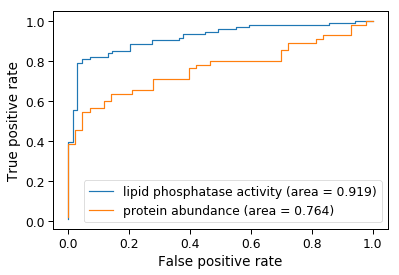

In [19]:
# plot ROC curve
with sns.plotting_context('paper', font_scale=1.4):
    mymethods = [#'average rank', 'gwCHASMplus', 
                 'lipid phosphatase activity', 'protein abundance']
    roc_plot(plot_df, mymethods)
    plt.savefig('CHASMplus/figures/figure_s6.pdf')

### Compare ranking of "functionally damaging" PTEN variants in TCGA

In [20]:
# read results
score_df = pd.read_table('CHASMplus/data/benchmark/mc3_results.txt')
score_df['SIFT'] = 1 - score_df['SIFT']
score_df['CHASM'] = 1 - score_df['CHASM']
score_df['FATHMM'] = -score_df['FATHMM']

# get the protein position of the mutation
score_df['Protein_position'] = score_df['HGVSp_Short'].str.extract('^p\.[A-Z]([0-9]+)[A-Z]$')

# merge in chasm2 scores
useful_cols = ['UID', 'p.value..0.', 'driver score', 'CHASM2', 'CHASM2_genome', 'CHASM2_pval', 'CHASM2_genome_pval', 'CHASM2_qval', 'CHASM2_genome_qval',]
chasm2_df = pd.read_table('CHASMplus/data/aggregated_results/PANCAN.txt', usecols=useful_cols).rename(columns={'driver':'CHASM2'})
score_df = pd.merge(score_df, chasm2_df, on='UID', how='left')

In [21]:
# process the saturation mutagenesis dataframe
df['HGVSp_Short'] = 'p.' + df['Variant (one letter)']
df['Hugo_Symbol'] = 'PTEN'
df['pten_class'] = 'neutral'
df.loc[df['lipid phosphatase activity']<-1, 'pten_class'] = 'functionally damaging'

In [22]:
score_df = pd.merge(score_df, df[['Hugo_Symbol', 'HGVSp_Short', 'pten_class']], 
                    on=['Hugo_Symbol', 'HGVSp_Short'],
                    how='left')

### Method comparison

In [23]:
# format dataframe with func scores
df['HGVS_pShort'] = 'p.' + df['Variant (one letter)']

# read in merged result info
merged_result = pd.read_table('CHASMplus/data/pten/pten_saturation_mutagenesis_results.txt')
merged_result['gwCHASMplus'] = merged_result['CHASM2']*0.969

# merge in func scores
merged_result = pd.merge(merged_result, df[['HGVSp_Short', 'lipid phosphatase activity', 'protein abundance', 'sift_pred']],
                         on='HGVSp_Short',
                         how='left')

# create a flag for lipid phosphatase activity
merged_result['lipid phosphatase activity flag'] = 0
merged_result.loc[merged_result['lipid phosphatase activity']<-1.11, 'lipid phosphatase activity flag'] = 1

# read the empirical null distribution file
null_dist = pd.read_table('CHASMplus/data/pten/pten_null_distribution.txt', index_col=0)

# calc the p-values
mypvals = utils.compute_p_value(merged_result['gwCHASMplus'].dropna(), null_dist['CHASM2_genome'].dropna())

# add p-value column
merged_result['gwCHASMplus p-value'] = mypvals

# multiple testing correction
merged_result['gwCHASMplus q-value'] = utils.bh_fdr(merged_result['gwCHASMplus p-value'])

# create flags for whether a method thinks a mutation is a driver
merged_result['CanDrA plus driver flag'] = np.nan
merged_result.loc[merged_result['CanDrA plus category']=='Driver', 'CanDrA plus driver flag'] = 1
merged_result.loc[merged_result['CanDrA plus category']=='Passenger', 'CanDrA plus driver flag'] = 0
merged_result['ParsSNP driver flag'] = np.nan
merged_result.loc[merged_result['ParsSNP']>0.1, 'ParsSNP driver flag'] = 1
merged_result.loc[(~merged_result['CanDrA plus'].isnull()) & (merged_result['ParsSNP']<=0.1), 'ParsSNP driver flag'] = 0
merged_result['gwCHASMplus driver flag'] = np.nan
merged_result.loc[merged_result['gwCHASMplus q-value']<=0.01, 'gwCHASMplus driver flag'] = 1
merged_result.loc[merged_result['gwCHASMplus q-value']>0.01, 'gwCHASMplus driver flag'] = 0
merged_result['SIFT driver flag'] = np.nan
merged_result.loc[merged_result['sift_pred']=='DAMAGING', 'SIFT driver flag'] = 1
merged_result.loc[merged_result['sift_pred']=='TOLERATED', 'SIFT driver flag'] = 0
merged_result.loc[merged_result['sift_pred']=='*DAMAGING', 'SIFT driver flag'] = 1

In [24]:
import sklearn.metrics as metrics
is_sbs = merged_result['Reference_Allele'].str.len()==1

def performance_metrics(ytrue, ypred, method=''):
    # get performance metrics
    prec, recall, f1, support = metrics.precision_recall_fscore_support(
        ytrue, ypred,
        labels=[0, 1], average=None,
    )
    precision = prec[1]
    sensitivity = recall[1]
    specificity = recall[0]
    f1_score = f1[1]
    support0, support1 = support
    
    # format results
    result_df = pd.DataFrame({
        'metric': ['sensitivity', 'specificity', 'precision', 'f1', 'support 0', 'support 1'],
        'score': [sensitivity, specificity, precision, f1_score, support0, support1],
        'method': method
    })
    return result_df

sift_result = performance_metrics(
    merged_result[is_sbs]['lipid phosphatase activity flag'], 
    merged_result[is_sbs]['SIFT driver flag'],
    method='SIFT'
)
parssnp_result = performance_metrics(
    merged_result[is_sbs]['lipid phosphatase activity flag'], 
    merged_result[is_sbs]['ParsSNP driver flag'],
    method='ParsSNP'
)
candra_result = performance_metrics(
    merged_result[is_sbs]['lipid phosphatase activity flag'], 
    merged_result[is_sbs]['CanDrA plus driver flag'],
    method='CanDrA'
)
chasmplus_result = performance_metrics(
    merged_result[is_sbs]['lipid phosphatase activity flag'], 
    merged_result[is_sbs]['gwCHASMplus driver flag'],
    method='gwCHASMplus'
)
performance_result = pd.concat([parssnp_result, candra_result, chasmplus_result])

In [25]:
performance_result

,method,metric,score
0,ParsSNP,sensitivity,0.916100
1,ParsSNP,specificity,0.416361
2,ParsSNP,precision,0.297059
3,ParsSNP,f1,0.448640
4,ParsSNP,support 0,1638.000000
5,ParsSNP,support 1,441.000000
0,CanDrA,sensitivity,1.000000
1,CanDrA,specificity,0.000000
2,CanDrA,precision,0.212121
3,CanDrA,f1,0.350000


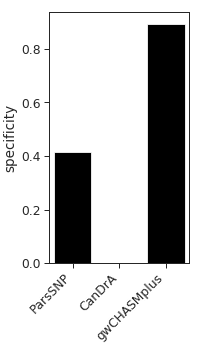

In [26]:
with sns.axes_style('ticks'), sns.plotting_context('paper',font_scale=1.4):
    #fig, axes = plt.subplots(1,2)
    #ax = axes[0]
    ax = plt.gca()
    plot_df = performance_result[performance_result['metric']=='specificity']
    sns.barplot(x='method', y='score', data=plot_df, color='black', )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', which='major', pad=3)
    ax.set_xlabel('')
    ax.set_ylabel('specificity')
    #ax = axes[1]
    #plot_df = performance_result[~performance_result['metric'].isin(['support 0', 'support 1', 'f1'])]
    #sns.barplot(x='method', y='score', hue='metric', data=plot_df, ax=ax)
    #plt.legend(bbox_to_anchor=(1.05, .7), loc=2, borderaxespad=0., title='metrics')
    plt.gcf().set_size_inches(3, 5)
    plt.tight_layout()
    plt.savefig('CHASMplus/figures/figure_5g_left.pdf')

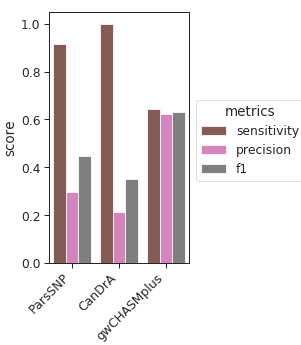

In [27]:
plot_df = performance_result[~performance_result['metric'].isin(['support 0', 'support 1', 'specificity'])]
with sns.axes_style('ticks'), sns.plotting_context('paper',font_scale=1.4):
    ax = plt.gca()
    sns.barplot(x='method', y='score', hue='metric', data=plot_df, palette=sns.color_palette()[5:])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', which='major', pad=3)
    plt.legend(bbox_to_anchor=(1.05, .65), loc=2, borderaxespad=0., title='metrics')
    ax.set_xlabel('')
    plt.gcf().set_size_inches(3, 5)
    plt.tight_layout()
    plt.savefig('CHASMplus/figures/figure_5g_right.pdf', bbox_inches='tight')

In [212]:
specificity = merged_result[is_sbs & (merged_result['lipid phosphatase activity flag']==0)]
chasmplus_parssnp = pd.crosstab(specificity['gwCHASMplus driver flag'], specificity['ParsSNP driver flag'])
chasmplus_candra = pd.crosstab(specificity['gwCHASMplus driver flag'], specificity['CanDrA plus driver flag'])
chasmplus_candra[0.0] = [0, 0]  # factor level is empty for candra
chasmplus_candra = chasmplus_candra[[0.0, 1.0]]

In [211]:
%%R -i chasmplus_parssnp,chasmplus_candra
#mcnemar.test(chasmplus_parssnp)
print('Specificity of CHASMplus vs ParsSNP')
chasmplus_parssnp <- as.matrix(chasmplus_parssnp)
print(mcnemar.test(chasmplus_parssnp))
print('Specificity of CHASMplus vs CanDrA')
chasmplus_candra <- as.matrix(chasmplus_candra)
mcnemar.test(chasmplus_candra)

[1] "Specificity of CHASMplus vs ParsSNP"

	McNemar's Chi-squared test with continuity correction

data:  chasmplus_parssnp
McNemar's chi-squared = 741.24, df = 1, p-value < 2.2e-16

[1] "Specificity of CHASMplus vs CanDrA"

	McNemar's Chi-squared test with continuity correction

data:  chasmplus_candra
McNemar's chi-squared = 1463, df = 1, p-value < 2.2e-16

